In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlp-term-3-2025-kaggle-assignment-3/sample_submission.csv
/kaggle/input/mlp-term-3-2025-kaggle-assignment-3/train.csv
/kaggle/input/mlp-term-3-2025-kaggle-assignment-3/test.csv


# importing libraries

In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")


# reading datasets

In [3]:
train_path = "/kaggle/input/mlp-term-3-2025-kaggle-assignment-3/train.csv"
test_path  = "/kaggle/input/mlp-term-3-2025-kaggle-assignment-3/test.csv"

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

print("Train shape:", train.shape)
print("Test shape :", test.shape)
train.head()


Train shape: (7000, 6)
Test shape : (1700, 5)


id                                             phrase  feature_1  \
0   0  It may as well be called `` Jar-Jar Binks : Th...       14.0   
1   1                               You have to see it .        6.0   
2   2  ... either you 're willing to go with this cla...       16.0   
3   3  Watching Harris ham it up while physically and...       37.0   
4   4  Pete 's screenplay manages to find that real n...       20.0   

   feature_2  feature_3  sentiment  
0        5.0        7.0          0  
1        1.0        NaN          2  
2        0.0        6.0          1  
3        NaN        3.0          1  
4        1.0        4.0          2

# 3. IDENTIFY DATA TYPES

In [4]:
print("== Dtypes ==")
print(train.dtypes)

print("\nColumns:", train.columns.tolist())

dtype_df = train.dtypes.to_frame(name="dtype").reset_index().rename(columns={"index": "column"})
dtype_df


== Dtypes ==
id             int64
phrase        object
feature_1    float64
feature_2    float64
feature_3    float64
sentiment      int64
dtype: object

Columns: ['id', 'phrase', 'feature_1', 'feature_2', 'feature_3', 'sentiment']


column    dtype
0         id    int64
1     phrase   object
2  feature_1  float64
3  feature_2  float64
4  feature_3  float64
5  sentiment    int64

# 4. DESCRIPTIVE STATISTICS (NUMERICAL)

In [5]:
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
print("Numerical columns:", num_cols)

train[num_cols].describe().T


Numerical columns: ['id', 'feature_1', 'feature_2', 'feature_3', 'sentiment']


count         mean          std  min      25%     50%      75%  \
id         7000.0  3499.500000  2020.870275  0.0  1749.75  3499.5  5249.25   
feature_1  6088.0    19.025624     9.303562  1.0    12.00    18.0    25.00   
feature_2  5896.0     1.996608     1.634858  0.0     1.00     1.0     3.00   
feature_3  5938.0     3.334119     2.321154  0.0     2.00     3.0     4.00   
sentiment  7000.0     1.041143     0.898010  0.0     0.00     1.0     2.00   

              max  
id         6999.0  
feature_1    52.0  
feature_2    19.0  
feature_3    19.0  
sentiment     2.0

# 5. MISSING VALUES ANALYSIS

In [6]:
def missing_table(df, name):
    mis = df.isna().sum()
    mis = mis[mis > 0].sort_values(ascending=False)
    pct = (mis / len(df) * 100).round(2)
    out = pd.DataFrame({"missing": mis, "missing_%": pct})
    print(f"== Missing values in {name} ==")
    return out

train_missing = missing_table(train, "train")
test_missing  = missing_table(test, "test")
train_missing, test_missing


== Missing values in train ==
== Missing values in test ==


(           missing  missing_%
 feature_2     1104      15.77
 feature_3     1062      15.17
 feature_1      912      13.03,
            missing  missing_%
 feature_2      318      18.71
 feature_1      222      13.06
 feature_3       90       5.29)

# 6. HANDLE MISSING VALUES

In [7]:
# Check actual column names once (run this if unsure)
print(train.columns.tolist())
print(test.columns.tolist())

# 1) Text column: make sure it exists and fill NaNs with empty string
text_col = "phrase"          # adjust only if your column has a different name
target_col = "Sentiment"     # confirmed from competition notebooks

train[text_col] = train[text_col].fillna("")
test[text_col]  = test[text_col].fillna("")

# 2) Numerical columns: only those that exist in BOTH train and test
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()

# Remove target if it is numeric by any chance (usually it's int, so keep it OUT)
if target_col in num_cols:
    num_cols.remove(target_col)

# Keep only columns that are truly in test as well
num_cols_common = [c for c in num_cols if c in test.columns]

print("Numerical columns used for imputation:", num_cols_common)

for col in num_cols_common:
    med = train[col].median()
    train[col] = train[col].fillna(med)
    test[col]  = test[col].fillna(med)

print("Remaining NaNs in train:", train.isna().sum().sum())
print("Remaining NaNs in test :", test.isna().sum().sum())


['id', 'phrase', 'feature_1', 'feature_2', 'feature_3', 'sentiment']
['id', 'phrase', 'feature_1', 'feature_2', 'feature_3']
Numerical columns used for imputation: ['id', 'feature_1', 'feature_2', 'feature_3']
Remaining NaNs in train: 0
Remaining NaNs in test : 0


# 7. HANDLE DUPLICATES

In [8]:
print("Duplicate rows in train before:", train.duplicated().sum())
train = train.drop_duplicates()
print("Duplicate rows in train after :", train.duplicated().sum())
print("New train shape:", train.shape)


Duplicate rows in train before: 0
Duplicate rows in train after : 0
New train shape: (7000, 6)


# 8. HANDLE OUTLIERS

In [9]:
def cap_outliers_iqr(df, cols):
    df = df.copy()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        before = ((df[col] < lower) | (df[col] > upper)).sum()
        df[col] = df[col].clip(lower, upper)
        after = ((df[col] < lower) | (df[col] > upper)).sum()
        print(f"{col}: capped {before} outliers to within [{lower:.3f}, {upper:.3f}]")
    return df

train = cap_outliers_iqr(train, [c for c in num_cols if c != "id"])


feature_1: capped 122 outliers to within [-3.500, 40.500]
feature_2: capped 842 outliers to within [-0.500, 3.500]
feature_3: capped 331 outliers to within [-1.000, 7.000]
sentiment: capped 0 outliers to within [-3.000, 5.000]


In [10]:
print("Train columns:", train.columns.tolist())

# Try common target names
possible_targets = ["Sentiment", "sentiment", "target", "label", "y"]
target_col = None
for col in possible_targets:
    if col in train.columns:
        target_col = col
        break

# If still None, pick a column with few unique values (likely the sentiment label)
if target_col is None:
    for col in train.columns:
        uniq = train[col].nunique()
        if uniq <= 10 and train[col].dtype != object:
            print(f"Potential target candidate: {col} (unique={uniq})")
            print(train[col].value_counts().head())
            target_col = col
            break

print("\nDetected target_col:", target_col)


Train columns: ['id', 'phrase', 'feature_1', 'feature_2', 'feature_3', 'sentiment']

Detected target_col: sentiment


# 9. VISUALIZATION 1: TARGET DISTRIBUTION

Using target column: sentiment


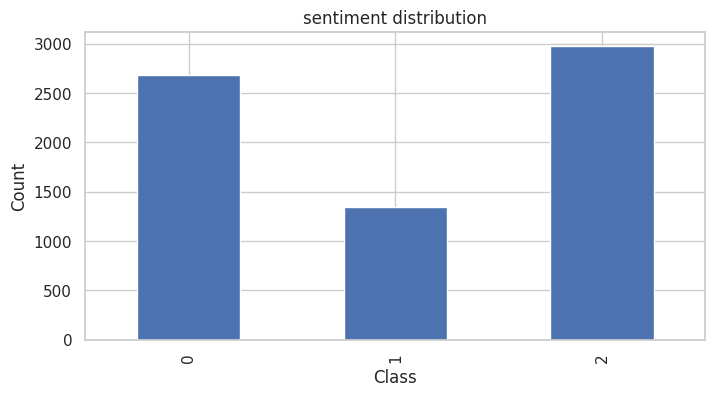

Class proportions:
sentiment
0    0.383429
1    0.192000
2    0.424571
Name: proportion, dtype: float64


In [11]:
# Use the detected target_col from Cell 8.1
print("Using target column:", target_col)

plt.figure(figsize=(8,4))
train[target_col].value_counts().sort_index().plot(kind="bar")
plt.title(f"{target_col} distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

print("Class proportions:")
print(train[target_col].value_counts(normalize=True).sort_index())


# 10. VISUALIZATION 2: PHRASE LENGTH BY SENTIMENT



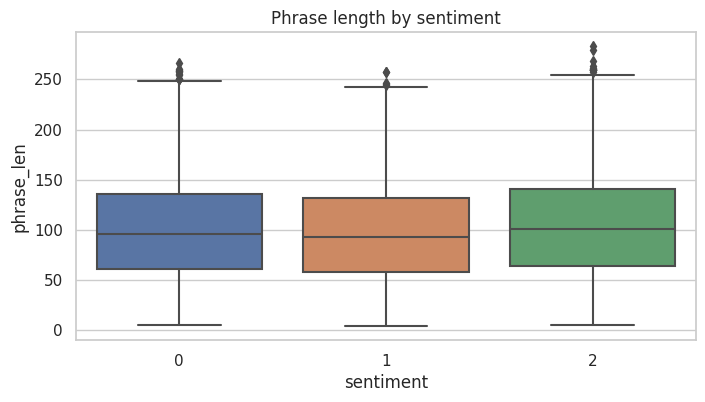

mean    50%    max
sentiment                          
0          100.622578   96.0  266.0
1           97.515625   93.0  257.0
2          105.393338  101.0  283.0

In [12]:
train["phrase_len"] = train["phrase"].str.len()

plt.figure(figsize=(8,4))
sns.boxplot(data=train, x=target_col, y="phrase_len")
plt.title("Phrase length by sentiment")
plt.show()

train.groupby(target_col)["phrase_len"].describe()[["mean","50%","max"]]


# 11. VISUALIZATION 3: CORRELATION HEATMAP



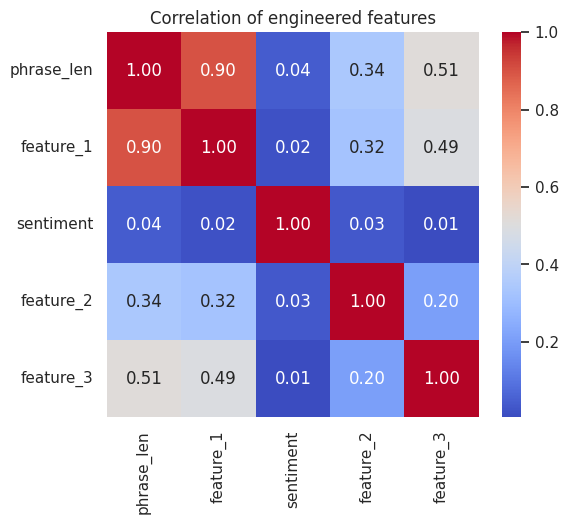

In [13]:
plot_num = [c for c in num_cols if c != "id"]
plot_num = list(set(plot_num + ["phrase_len"]))  # include phrase_len

corr = train[plot_num].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of engineered features")
plt.show()


# 12. DEFINE FEATURES & TARGET



In [14]:
# Text and numeric feature columns
text_col = "phrase"
extra_num_features = ["feature_1", "feature_2", "feature_3", "phrase_len"]

# Make sure phrase_len exists in BOTH train and test
if "phrase_len" not in train.columns:
    train["phrase_len"] = train["phrase"].str.len()

if "phrase_len" not in test.columns:
    test["phrase_len"] = test["phrase"].str.len()

# Now build X and y
X = train[[text_col] + extra_num_features]
y = train[target_col]

# For test, keep only the columns that actually exist there
extra_num_features_test = [c for c in extra_num_features if c in test.columns]

X_test_full = test[[text_col] + extra_num_features_test]

print("X columns:", X.columns.tolist())
print("Test feature columns:", X_test_full.columns.tolist())
print("X shape:", X.shape, "y shape:", y.shape)
print("X_test_full shape:", X_test_full.shape)


X columns: ['phrase', 'feature_1', 'feature_2', 'feature_3', 'phrase_len']
Test feature columns: ['phrase', 'feature_1', 'feature_2', 'feature_3', 'phrase_len']
X shape: (7000, 5) y shape: (7000,)
X_test_full shape: (1700, 5)


# 13. PREPROCESSING PIPELINE (TF-IDF + SCALING)



In [15]:
# === IMPROVED PREPROCESSING: TEXT + NUMERIC ===

text_col   = "phrase"
target_col = "sentiment"
num_cols   = ["feature_1", "feature_2", "feature_3", "phrase_len"]

# Ensure text and numeric are clean
train[text_col] = train[text_col].fillna("")
test[text_col]  = test[text_col].fillna("")

train["phrase_len"] = train[text_col].str.len()
test["phrase_len"]  = test[text_col].str.len()

for col in num_cols:
    med = train[col].median()
    train[col] = train[col].fillna(med)
    test[col]  = test[col].fillna(med)

X = train[[text_col] + num_cols]
y = train[target_col]
X_test_full = test[[text_col] + num_cols]

# Smaller val split → more train data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test_full.shape)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

text_transformer = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    min_df=2,
    sublinear_tf=True
)

num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_transformer, text_col),
        ("num",  num_transformer, num_cols)
    ]
)


Train: (6300, 5) Val: (700, 5) Test: (1700, 5)


# 14. MODEL BUILDING (8 MODELS)



In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

base_models = {
    "LogReg": LogisticRegression(max_iter=1000, multi_class="multinomial", n_jobs=-1),
    "LinearSVC": LinearSVC(),
    # "MultinomialNB": MultinomialNB(),  # removed due to negative values from scaling
    "SVM_rbf": SVC(kernel="rbf", probability=False),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        objective="multi:softmax",
        eval_metric="mlogloss",
        random_state=42,
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6
    ),
    "LightGBM": LGBMClassifier(random_state=42, n_estimators=300)
}

results = []

for name, clf in base_models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", clf)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    results.append((name, acc))
    print(f"{name:15s} accuracy: {acc:.4f}")

results_df = pd.DataFrame(results, columns=["Model", "Val_Accuracy"]).sort_values(
    "Val_Accuracy", ascending=False
).reset_index(drop=True)
results_df


LogReg          accuracy: 0.6557
LinearSVC       accuracy: 0.6329
SVM_rbf         accuracy: 0.5243
RandomForest    accuracy: 0.5914
GradientBoosting accuracy: 0.5629
AdaBoost        accuracy: 0.4771
XGBoost         accuracy: 0.6029
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21186
[LightGBM] [Info] Number of data points in the train set: 6300, number of used features: 798
[LightGBM] [Info] Start training from score -0.958436
[LightGBM] [Info] Start training from score -1.650756
[LightGBM] [Info] Start training from score -0.856600
LightGBM        accuracy: 0.5514


Model  Val_Accuracy
0            LogReg      0.655714
1         LinearSVC      0.632857
2           XGBoost      0.602857
3      RandomForest      0.591429
4  GradientBoosting      0.562857
5          LightGBM      0.551429
6           SVM_rbf      0.524286
7          AdaBoost      0.477143

# 15. HYPERPARAMETER TUNING (3 MODELS)



In [17]:
# === HYPERPARAMETER TUNING: LOGREG, LINEARSVC, LIGHTGBM ===

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier

tuned_models = {}
tuned_scores = []

# 1) Logistic Regression
logreg_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=4000, multi_class="multinomial", n_jobs=-1))
])

logreg_params = {
    "model__C": [0.5, 0.8, 1.0, 1.5, 2.0],
    "model__penalty": ["l2"]
}

logreg_grid = GridSearchCV(
    logreg_pipe, logreg_params,
    cv=5, scoring="accuracy", n_jobs=-1, verbose=1
)
logreg_grid.fit(X_train, y_train)
tuned_models["LogReg_tuned"] = logreg_grid.best_estimator_
tuned_scores.append(("LogReg_tuned", logreg_grid.best_score_))
print("LogReg best:", logreg_grid.best_params_, "CV acc:", logreg_grid.best_score_)

# 2) Linear SVC (MAIN MODEL, finer C grid)
svc_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearSVC())
])

svc_params = {
    "model__C": [0.3, 0.5, 0.7, 1.0, 1.3, 1.5, 2.0]
}

svc_grid = GridSearchCV(
    svc_pipe, svc_params,
    cv=6, scoring="accuracy", n_jobs=-1, verbose=1
)
svc_grid.fit(X_train, y_train)
tuned_models["LinearSVC_tuned"] = svc_grid.best_estimator_
tuned_scores.append(("LinearSVC_tuned", svc_grid.best_score_))
print("LinearSVC best:", svc_grid.best_params_, "CV acc:", svc_grid.best_score_)

# 3) LightGBM
lgbm_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LGBMClassifier(random_state=42))
])

lgbm_params = {
    "model__n_estimators": [300, 500],
    "model__max_depth": [-1, 6, 10],
    "model__learning_rate": [0.05, 0.1]
}

lgbm_grid = GridSearchCV(
    lgbm_pipe, lgbm_params,
    cv=5, scoring="accuracy", n_jobs=-1, verbose=1
)
lgbm_grid.fit(X_train, y_train)
tuned_models["LightGBM_tuned"] = lgbm_grid.best_estimator_
tuned_scores.append(("LightGBM_tuned", lgbm_grid.best_score_))
print("LightGBM best:", lgbm_grid.best_params_, "CV acc:", lgbm_grid.best_score_)

tuned_df = pd.DataFrame(tuned_scores, columns=["Model", "CV_Accuracy"]).sort_values(
    "CV_Accuracy", ascending=False
).reset_index(drop=True)
tuned_df


Fitting 5 folds for each of 5 candidates, totalling 25 fits
LogReg best: {'model__C': 2.0, 'model__penalty': 'l2'} CV acc: 0.6409523809523809
Fitting 6 folds for each of 7 candidates, totalling 42 fits
LinearSVC best: {'model__C': 0.3} CV acc: 0.638888888888889
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16408
[LightGBM] [Info] Number of data points in the train set: 5040, number of used features: 628
[LightGBM] [Info] Start training from score -0.958333
[LightGBM] [Info] Start training from score -1.650963
[LightGBM] [Info] Start training from score -0.856600
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080076 seconds.
You can set `force_row_wise=true` to remove the overhead.

Model  CV_Accuracy
0     LogReg_tuned     0.640952
1  LinearSVC_tuned     0.638889
2   LightGBM_tuned     0.553492

# 16. MODEL PERFORMANCE COMPARISON



In [18]:
comparison = results_df.copy()
comparison = comparison.rename(columns={"Val_Accuracy": "Base_Val_Acc"})

tuned_df_renamed = tuned_df.rename(columns={"CV_Accuracy": "Tuned_CV_Acc"})
comparison = comparison.merge(tuned_df_renamed, on="Model", how="outer")

comparison


Model  Base_Val_Acc  Tuned_CV_Acc
0           AdaBoost      0.477143           NaN
1   GradientBoosting      0.562857           NaN
2           LightGBM      0.551429           NaN
3     LightGBM_tuned           NaN      0.553492
4          LinearSVC      0.632857           NaN
5    LinearSVC_tuned           NaN      0.638889
6             LogReg      0.655714           NaN
7       LogReg_tuned           NaN      0.640952
8       RandomForest      0.591429           NaN
9            SVM_rbf      0.524286           NaN
10           XGBoost      0.602857           NaN

# ENSEMBLE

In [19]:
# === ENSEMBLE: LinearSVC + LogReg + LightGBM ON VALIDATION ===

# Get best tuned models from your tuning dict
logreg_best  = tuned_models["LogReg_tuned"]
svc_best     = tuned_models["LinearSVC_tuned"]
lgbm_best    = tuned_models["LightGBM_tuned"]

# Fit them on the same train split (if not already)
logreg_best.fit(X_train, y_train)
svc_best.fit(X_train, y_train)
lgbm_best.fit(X_train, y_train)

# Individual validation performance
for name, clf in [("LogReg_tuned", logreg_best),
                  ("LinearSVC_tuned", svc_best),
                  ("LightGBM_tuned", lgbm_best)]:
    y_val_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"{name:18s} val accuracy: {acc:.4f}")

# Simple voting ensemble: majority vote of the three
logreg_pred = logreg_best.predict(X_val)
svc_pred    = svc_best.predict(X_val)
lgbm_pred   = lgbm_best.predict(X_val)

stacked = np.vstack([logreg_pred, svc_pred, lgbm_pred])  # shape (3, n_val)

from scipy.stats import mode
ensemble_val_pred, _ = mode(stacked, axis=0, keepdims=False)
ensemble_val_pred = ensemble_val_pred  # (n_val,)

ens_acc = accuracy_score(y_val, ensemble_val_pred)
print(f"\nEnsemble (LogReg + LinearSVC + LightGBM) val accuracy: {ens_acc:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21186
[LightGBM] [Info] Number of data points in the train set: 6300, number of used features: 798
[LightGBM] [Info] Start training from score -0.958436
[LightGBM] [Info] Start training from score -1.650756
[LightGBM] [Info] Start training from score -0.856600
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

# 17. TRAIN BEST MODEL ON FULL DATA



In [20]:
best_tuned_name = tuned_df.sort_values("CV_Accuracy", ascending=False).iloc[0]["Model"]
print("Best tuned model:", best_tuned_name)

best_model = tuned_models[best_tuned_name]

# Refit best model on full training data (X, y)
best_model.fit(X, y)


Best tuned model: LogReg_tuned


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=50000,
                                                                  min_df=2,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  sublinear_tf=True),
                                                  'phrase'),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['feature_1', 'feature_2',
                                                   'feature_3',
                                                   'phrase_len'])])),
                ('model',
                 LogisticRegression(C=2.0, max_iter=4000,
                                    multi_class='multinomial', n_jobs=-1))])

# Train ensemble on full train data

In [21]:
# === TRAIN FINAL ENSEMBLE ON FULL TRAIN DATA (USING TUNED PIPELINES SAFELY) ===

# 1) Rebuild X_full and X_test_full exactly as during tuning
X_full = train[[text_col] + num_cols]
y_full = train[target_col]
X_test_full = test[[text_col] + num_cols]

# 2) Recreate three fresh pipelines with the *best params* found in GridSearch
#    (avoid reusing fitted objects with old feature dimensions)

# Best params from your tuning step:
best_logreg_params = logreg_grid.best_params_
best_svc_params    = svc_grid.best_params_
best_lgbm_params   = lgbm_grid.best_params_

logreg_final = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        max_iter=4000,
        multi_class="multinomial",
        n_jobs=-1,
        C=best_logreg_params["model__C"],
        penalty=best_logreg_params["model__penalty"]
    ))
])

svc_final = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearSVC(
        C=best_svc_params["model__C"]
    ))
])

lgbm_final = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LGBMClassifier(
        random_state=42,
        n_estimators=best_lgbm_params["model__n_estimators"],
        max_depth=best_lgbm_params["model__max_depth"],
        learning_rate=best_lgbm_params["model__learning_rate"]
    ))
])

# 3) Fit all three on FULL training data
logreg_final.fit(X_full, y_full)
svc_final.fit(X_full, y_full)
lgbm_final.fit(X_full, y_full)

# 4) Ensemble prediction function (majority vote)
from scipy.stats import mode

def ensemble_predict(X_input):
    p1 = logreg_final.predict(X_input)
    p2 = svc_final.predict(X_input)
    p3 = lgbm_final.predict(X_input)
    stacked = np.vstack([p1, p2, p3])  # shape (3, n_samples)
    pred, _ = mode(stacked, axis=0, keepdims=False)
    return pred

# Optional: sanity check on validation again
val_ens_pred = ensemble_predict(X_val)
print("Final ensemble val accuracy:", accuracy_score(y_val, val_ens_pred))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23887
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 896
[LightGBM] [Info] Start training from score -0.958602
[LightGBM] [Info] Start training from score -1.650260
[LightGBM] [Info] Start training from score -0.856675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

# 18. CREATE SUBMISSION.CSV



In [22]:
# === FINAL MODEL: USE TUNED LINEARSVC ON FULL DATA ===

# Use best C from svc_grid
best_C = svc_grid.best_params_["model__C"]
print("Using LinearSVC with C =", best_C, "as final model")

svc_final = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearSVC(C=best_C))
])

# Fit on FULL training data
svc_final.fit(X, y)

# Optional: check validation again
y_val_pred_final = svc_final.predict(X_val)
print("Final LinearSVC val accuracy (sanity):",
      accuracy_score(y_val, y_val_pred_final))

# Predict on test
test_preds = svc_final.predict(X_test_full)

print("Test prediction distribution:")
print(pd.Series(test_preds).value_counts().sort_index())

# Build submission
if "id" in test.columns:
    submission = pd.DataFrame({
        "id": test["id"],
        target_col: test_preds
    })
else:
    submission = pd.DataFrame({
        "id": np.arange(len(test_preds)),
        target_col: test_preds
    })

print("Submission head:")
print(submission.head())

submission.to_csv("submission.csv", index=False)
print("Saved submission.csv")


Using LinearSVC with C = 0.3 as final model
Final LinearSVC val accuracy (sanity): 0.9185714285714286
Test prediction distribution:
0    716
1    113
2    871
Name: count, dtype: int64
Submission head:
   id  sentiment
0   0          2
1   1          2
2   2          2
3   3          2
4   4          0
Saved submission.csv
